In [ ]:
##Improvements to Mapping Traffic Collsions

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import plotly.express as px
from sodapy import Socrata
import requests

In [3]:
##2010 Traffic Collisions in LA County

In [4]:
gdf = gpd.read_file('2010_.csv')

In [5]:
gdf['lat']=gdf['Location'].str.extract(r'\((.*),.*\)')
gdf['long']=gdf['Location'].str.extract(r'\(.*,(.*)\)')
gdf.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified),geometry,lat,long
0,100104094,01/03/2010,01/02/2010,1945,01,Central,0159,997,TRAFFIC COLLISION,,...,"(34.0404, -118.233)",23082,533,1287,,9,28,None,34.0404,-118.233
1,100104092,01/02/2010,01/02/2010,1833,01,Central,0161,997,TRAFFIC COLLISION,0605,...,"(34.0487, -118.2627)",23078,546,1050,,9,76,None,34.0487,-118.2627
2,100204062,01/02/2010,01/02/2010,1345,02,Rampart,0295,997,TRAFFIC COLLISION,,...,"(34.0404, -118.2822)",22723,697,1521,,11,8,None,34.0404,-118.2822
3,100204052,01/02/2010,01/02/2010,0715,02,Rampart,0248,997,TRAFFIC COLLISION,,...,"(34.0594, -118.2644)",23078,566,1047,,11,67,None,34.0594,-118.2644
4,100304112,01/02/2010,01/02/2010,1550,03,Southwest,0397,997,TRAFFIC COLLISION,,...,"(34.0037, -118.3002)",24027,733,1048,7,14,35,None,34.0037,-118.3002


In [6]:
gdf = gpd.GeoDataFrame(gdf, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(gdf.long, gdf.lat))

In [7]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

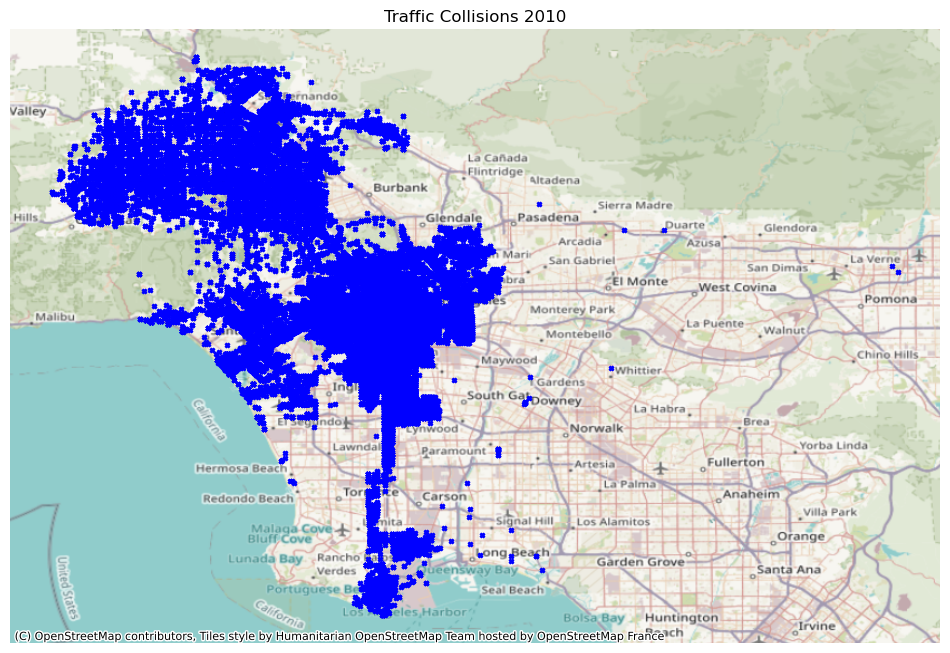

In [8]:
fig, ax = plt.subplots(figsize=(12,12))

ax = gdf.clip([-189,18,-66,71]).plot(ax=ax, 
        marker='X',
        markersize=10,
        color='blue')

ax.axis('off')

ax.set_title('Traffic Collisions 2010')

ctx.add_basemap(ax, crs=4326)

In [9]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 44976 entries, 0 to 44975
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype   
---  ------                             --------------  -----   
 0   DR Number                          44976 non-null  object  
 1   Date Reported                      44976 non-null  object  
 2   Date Occurred                      44976 non-null  object  
 3   Time Occurred                      44976 non-null  object  
 4   Area ID                            44976 non-null  object  
 5   Area Name                          44976 non-null  object  
 6   Reporting District                 44976 non-null  object  
 7   Crime Code                         44976 non-null  object  
 8   Crime Code Description             44976 non-null  object  
 9   MO Codes                           44976 non-null  object  
 10  Victim Age                         44976 non-null  object  
 11  Victim Sex                       

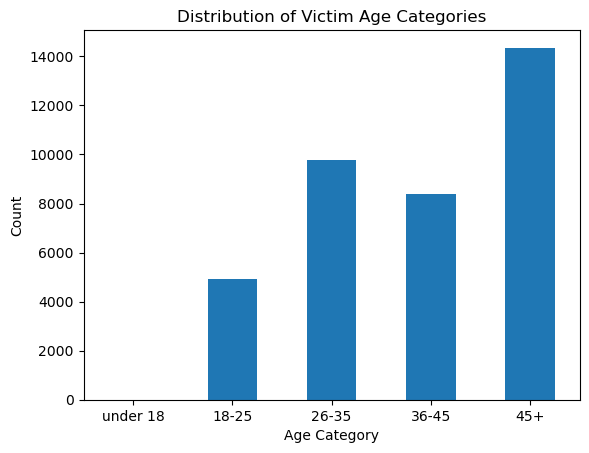

In [10]:
import pandas as pd

# Assuming you have a DataFrame named 'df' with a 'Victim Age' column

# Convert 'Victim Age' column to numeric, coerce errors to NaN for non-numeric values
gdf['Victim Age'] = pd.to_numeric(gdf['Victim Age'], errors='coerce')

# Drop rows with NaN values in the 'Victim Age' column
gdf = gdf.dropna(subset=['Victim Age'])

# Now 'Victim Age' should contain only numeric values

# Create a new column 'age_by_cat' to store the categories
gdf['age_by_cat'] = pd.cut(gdf['Victim Age'], bins=[0, 18, 25, 35, 45, float('inf')], labels=['under 18', '18-25', '26-35', '36-45', '45+'], right=False, include_lowest=True)

# Plotting
gdf['age_by_cat'].value_counts().sort_index().plot(kind='bar', rot=0)
plt.title('Distribution of Victim Age Categories')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.show()


In [11]:
age_cat = []
for age in gdf['Victim Age']: 
    if pd.isnull(age):  # Check if age is missing
        age_cat.append('NaN')  # Append 'Missing' category
        #missing_count += 1  # Increment missing count
    elif age < 18: 
        age_cat.append('under 18')
    elif 18 <= age <= 24: 
        age_cat.append('18-24')
    elif 25 <= age <= 34:
        age_cat.append('25-34')
    elif 35 <= age <= 44:
        age_cat.append('35-44')
    elif 45 <= age <= 54: 
        age_cat.append('45-54')
    elif 55 <= age <= 64:
        age_cat.append('55-64')
    elif age >= 65:
        age_cat.append('65+')
# add this new variable to the dataframe next
gdf['Victim Age'] = age_cat

#check to see if added to data frame correctly
gdf.head(2)

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified),geometry,lat,long,age_by_cat
0,100104094,01/03/2010,01/02/2010,1945,01,Central,0159,997,TRAFFIC COLLISION,,...,23082,533,1287,,9,28,POINT (-118.23300 34.04040),34.0404,-118.233,26-35
1,100104092,01/02/2010,01/02/2010,1833,01,Central,0161,997,TRAFFIC COLLISION,0605,...,23078,546,1050,,9,76,POINT (-118.26270 34.04870),34.0487,-118.2627,26-35


In [1]:
gdf.age_by_cat.count()

NameError: name 'gdf' is not defined

In [31]:
gdf['Victim Age'].plot.bar(x='age_by_cat',
                        y='count',
                  title='LA Traffic collisions sorted by Victim Age')

TypeError: no numeric data to plot

In [16]:
race = getattr(gdf,'Victim Descent').unique().tolist()
print(race)

['A', 'H', 'W', 'O', 'B', '', 'X', 'V', 'U', 'F', 'K', 'J', 'C', 'Z', 'I', 'D', 'S', 'P', 'G']


In [ ]:
fig = px.bar(
        gpd,
        x='Victim Descent',
        title='LA Traffic Collisions sorted by Victim Descent, 2020',
        color='red',
        labels={ 
            'A' : 'Other Asian',
            'B' : 'Black',
            'C' : 'Chinese',
            'D' : 'Cambodian',
            'F' : 'Filipino',
            'G' : 'Guamanian',
            'H' : 'Hispanic/ Latin/ Mexican',
            'I' : 'American Indian/ Alaskan Native',
            'J' : 'Japanese',
            'K' : 'Korean',
            'L' : 'Laotian',
            'O' : 'Other',
            'P' : 'Pacific Islander',
            'S' : 'Samoan',
            'U' : 'Hawaiian',
            'V' : 'Vietnamese',
            'W' : 'White',
            'X' : 'Unknown',
            'Z' : 'Asian Indian'  
        }
)
# get rid of white lines inside the bars
fig.update_traces(marker_line_width=0)

# Update observation labels
fig.update_traces(text=['Other Asian', 'Black', 'Chinese'], textposition='outside')

# show the figure
fig.show()

In [13]:
Area = ["West LA","Hollywood", "Compton"]

AttributeError: Stamen

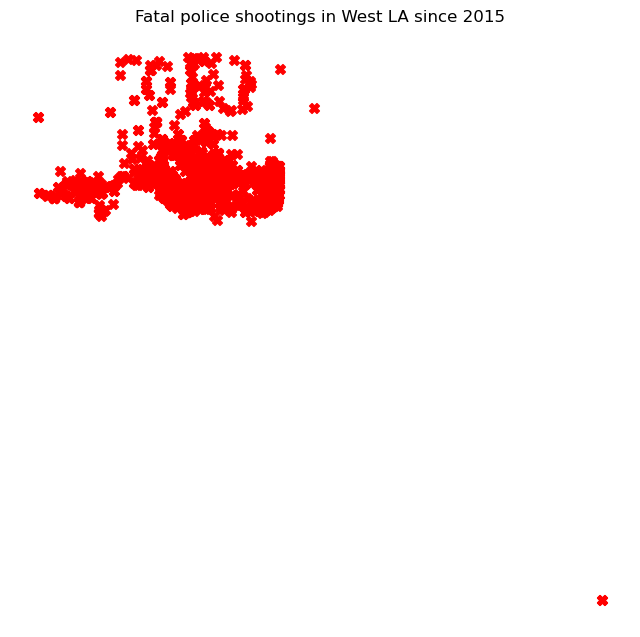

In [17]:

for city in Area:

  
    fig, ax = plt.subplots(figsize=(8,8))

    gdf[gdf['Area Name'] == city].plot(ax=ax, 
                          marker='X',
                          markersize=50,
                          color='red')

    ax.axis('off')
  
    ax.set_title('Fatal police shootings in '+str(city) + ' since 2015')

    ctx.add_basemap(ax, source=ctx.providers.Stamen.Toner, crs=4326)

In [16]:
gdf

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified),geometry,lat,long,age_by_cat
0,100104094,01/03/2010,01/02/2010,1945,01,Central,0159,997,TRAFFIC COLLISION,,...,23082,533,1287,,9,28,POINT (-118.23300 34.04040),34.0404,-118.233,26-35
1,100104092,01/02/2010,01/02/2010,1833,01,Central,0161,997,TRAFFIC COLLISION,0605,...,23078,546,1050,,9,76,POINT (-118.26270 34.04870),34.0487,-118.2627,26-35
3,100204052,01/02/2010,01/02/2010,0715,02,Rampart,0248,997,TRAFFIC COLLISION,,...,23078,566,1047,,11,67,POINT (-118.26440 34.05940),34.0594,-118.2644,36-45
5,100404063,01/02/2010,01/02/2010,1813,04,Hollenbeck,0451,997,TRAFFIC COLLISION,,...,23450,534,953,,9,38,POINT (-118.22710 34.05100),34.051,-118.2271,36-45
6,100904051,01/02/2010,01/02/2010,1230,09,Van Nuys,0981,997,TRAFFIC COLLISION,,...,19732,335,565,6,7,83,POINT (-118.45960 34.15270),34.1527,-118.4596,45+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44971,112004027,12/31/2010,12/31/2010,1715,20,Olympic,2055,997,TRAFFIC COLLISION,0605,...,22723,,1246,,12,89,POINT (-118.29580 34.05270),34.0527,-118.2958,45+
44972,112004001,01/01/2011,12/31/2010,2245,20,Olympic,2042,997,TRAFFIC COLLISION,1309 2002,...,23080,611,605,,7,86,POINT (-118.31430 34.05450),34.0545,-118.3143,45+
44973,112004005,01/01/2011,12/31/2010,2325,20,Olympic,2015,997,TRAFFIC COLLISION,,...,22721,582,936,16,8,89,POINT (-118.29170 34.07630),34.0763,-118.2917,45+
44974,112104475,01/05/2011,12/31/2010,2200,21,Topanga,2183,997,TRAFFIC COLLISION,1501,...,19346,310,650,,4,49,POINT (-118.63020 34.16180),34.1618,-118.6302,45+


In [ ]:

gdf = gpd.GeoDataFrame(
    arrests_mini, geometry=gpd.points_from_xy(arrests_mini.lon, arrests_mini.lat),crs=4326)


gdf.plot()


In [ ]:
#Importing 2020 crash data 

In [21]:
gdf2 = gpd.read_file('2020.csv')

In [23]:
gdf2['lat']=gdf2['Location'].str.extract(r'\((.*),.*\)')
gdf2['long']=gdf2['Location'].str.extract(r'\(.*,(.*)\)')
gdf2.head()

,DR Number,Date Reported,Date Occurred,Time Occurred,Area ID,Area Name,Reporting District,Crime Code,Crime Code Description,MO Codes,...,Location,Zip Codes,Census Tracts,Precinct Boundaries,LA Specific Plans,Council Districts,Neighborhood Councils (Certified),geometry,lat,long
0,201404116,01/02/2020,01/02/2020,1400,14,Pacific,1497,997,TRAFFIC COLLISION,3006 3026 3034 3037 3101 3401 3701 4014,...,"(33.9454, -118.3711)",23676,2340,445,10,10,16,None,33.9454,-118.3711
1,202105187,01/27/2020,01/02/2020,0725,21,Topanga,2155,997,TRAFFIC COLLISION,3006 3030 3028 3101 4021 3032 3037,...,"(34.1865, -118.6103)",4278,297,1473,,4,49,None,34.1865,-118.6103
2,201309786,01/02/2020,01/02/2020,0930,13,Newton,1352,997,TRAFFIC COLLISION,,...,"(34.0039, -118.2653)",22727,716,1342,7,13,,None,34.0039,-118.2653
3,200905447,02/03/2020,01/02/2020,1740,09,Van Nuys,0905,997,TRAFFIC COLLISION,3003 3037 3025 3104 4009 1218,...,"(34.2057, -118.4575)",19733,218,581,,3,18,None,34.2057,-118.4575
4,200306568,02/13/2020,01/02/2020,1415,03,Southwest,0363,997,TRAFFIC COLLISION,4025 3037 3002 3028 3101,...,"(34.011, -118.3351)",22725,761,1024,7,12,54,None,34.011,-118.3351


In [25]:
gdf2 = gpd.GeoDataFrame(gdf2, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(gdf2.long, gdf2.lat))

In [18]:
gdf2 = gpd.GeoDataFrame(gdf, 
                       crs='epsg:4326',
                       geometry=gpd.points_from_xy(gdf2.long, gdf2.lat))

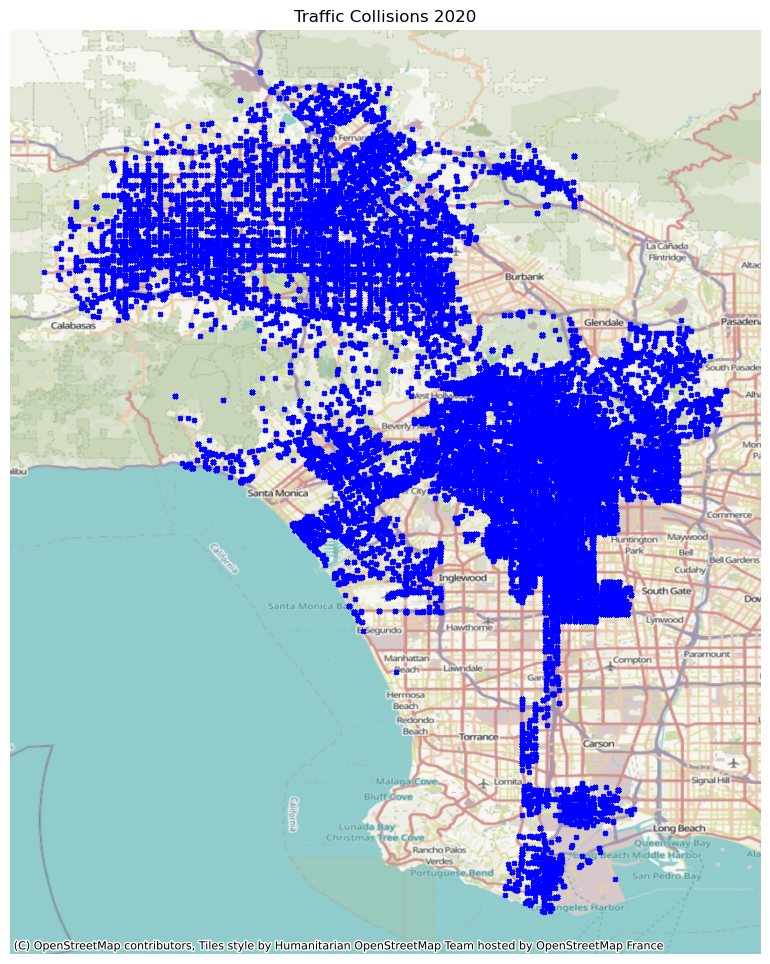

In [27]:
fig, ax = plt.subplots(figsize=(12,12))

ax = gdf2.clip([-189,18,-66,71]).plot(ax=ax, 
        marker='X',
        markersize=10,
        color='blue')

ax.axis('off')

ax.set_title('Traffic Collisions 2020')


ctx.add_basemap(ax, crs=4326)